In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-31 14:21:56.408290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 14:21:56.408315: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
from ML_classes.MLPModel import MLPModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

#max_value_energy = df["energy(kWh/hh)"].max()
#df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
#df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000153")
hh.pop("LCLid")
#hh = hh.set_index("tstp")
#hh = hh.resample("H").sum()
#hh = hh.reset_index()

hh_max = hh['energy(kWh/hh)'].max()
hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)

/tmp/ipykernel_261440/4013545935.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)


In [5]:
# Initiating the class
deep_learner = MLPModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24*2,
layer_depths = [30],
layer_count= 1,
epochs = 20,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
# Fitting the model

model = deep_learner.MLPModel()

Epoch 1/20


2022-03-31 14:22:01.319883: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 14:22:01.320269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 14:22:01.320336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-31 14:22:01.320401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-31 14:22:01.320459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

132/132 [==============================] - 1s 2ms/step - loss: 0.0196 - val_loss: 0.0087
Epoch 2/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 3/20
132/132 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 4/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 5/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0055
Epoch 6/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 7/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 8/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 9/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 10/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 11/2

In [7]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1470      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


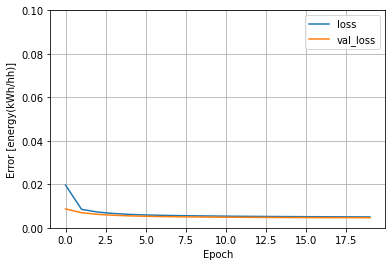

In [8]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [energy(kWh/hh)]')
    plt.legend()
    plt.grid(True)
plot_loss(deep_learner.history)

In [9]:
# Defining the lag that we used for training of the model 
lag_model = 48
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

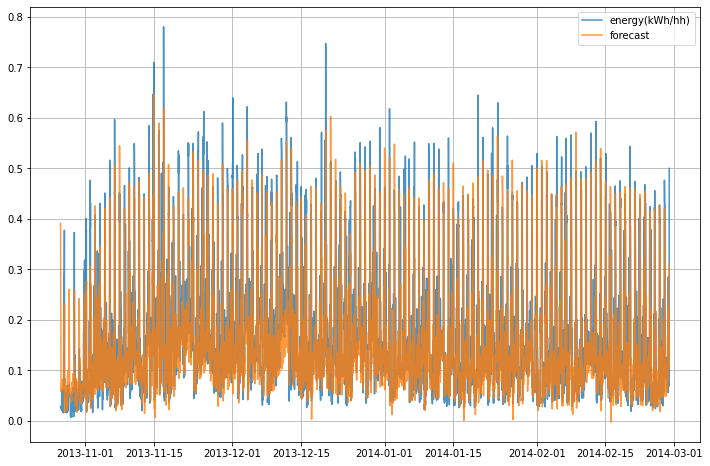

In [10]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_261440/2078647226.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


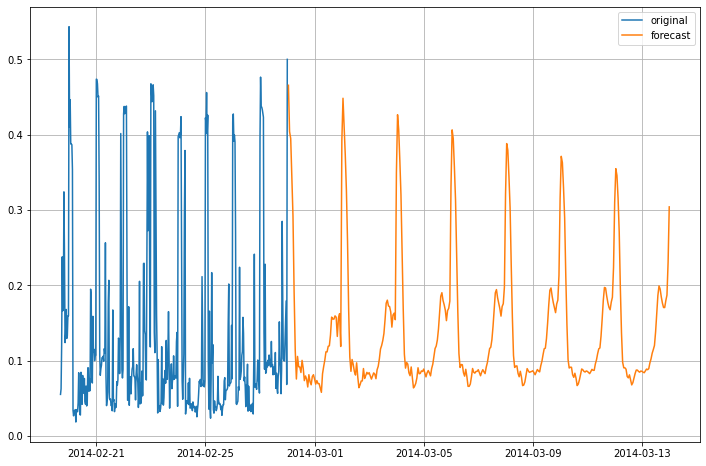

In [11]:

#Forecasting n steps ahead
n_ahead = 168*2
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [12]:
deep_learner.eval.MSE()

0.004628027649319177

In [13]:
deep_learner.eval.RMSE()

0.06802960862241658

In [14]:
deep_learner.eval.MAE()

0.04602364977150086

In [15]:
deep_learner.eval.MAPE()

43.14264778401624

In [16]:
peaks, peak_dates, peak_indexes, res = deep_learner.eval.peak_daily_consumption()
pred = deep_learner.predict()
preds = [pred[x] for x in peak_indexes]
difference = [peaks[x] - preds[x] for x in range(len(peaks))]
res


25.800344356624432

In [17]:
#preds

In [18]:
#peaks

In [19]:
#difference

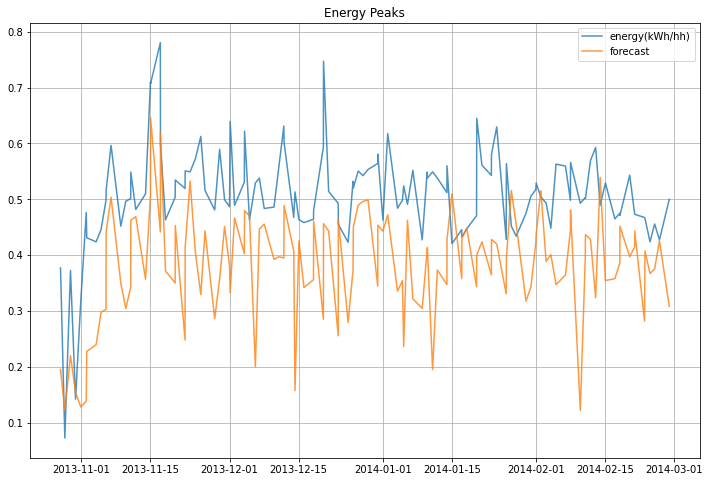

In [20]:
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat


hat_frame = pd.DataFrame({
    'tstp': peak_dates, 
    'energy(kWh/hh)': peaks,
    'forecast': preds, 
    
    'type': 'forecast'
})

# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=hat_frame,
    label=dtype,
    alpha=0.8
  )
plt.title( "Energy Peaks")
plt.legend()
plt.grid()

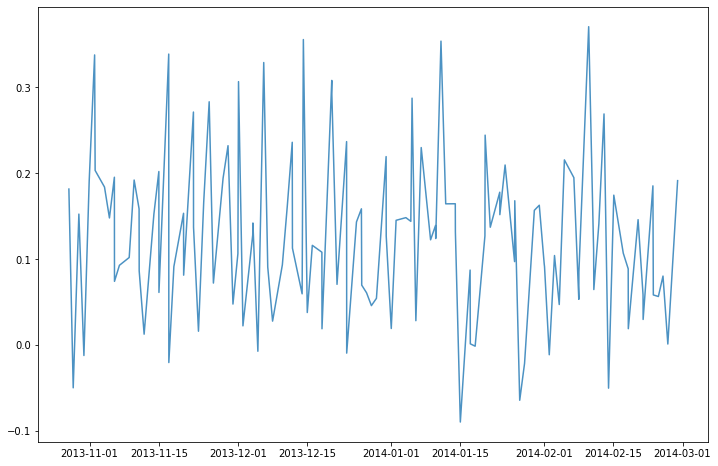

In [21]:
plt.figure(figsize=(12, 8))
hat_frame = pd.DataFrame({
    'tstp': peak_dates, 
    'difference': difference,
    
    'type': 'forecast'
})

plt.plot(
    'tstp',
    'difference',
    data=hat_frame,
    label=dtype,
    alpha=0.8
  )

In [22]:
#train for all houses
lclid_list = df['LCLid'].unique().tolist()
#print(type(lclid_list))
mse = []
rmse = []
mae = []
mape = []
daily_peak_eval = []
for lclid in lclid_list:
    #print(lclid)


    hh = find_household(lclid)
    hh.pop("LCLid")
    #hh = hh.set_index("tstp")
    #hh = hh.resample("H").sum()
    #hh = hh.reset_index()

    hh_max = hh['energy(kWh/hh)'].max()
    hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
    
    # Initiating the class
    deep_learner = MLPModel(
        data = hh,
        Y_var = 'energy(kWh/hh)',
        lag = 24*2,
        layer_depths = [30],
        layer_count= 1,
        epochs = 20,
        batch_size = 256,
        train_test_split = 0.15
    )
    #training
    model = deep_learner.MLPModel()
    
    mse.append(deep_learner.eval.MSE())
    rmse.append(deep_learner.eval.RMSE())
    mae.append(deep_learner.eval.MAE())
    mape.append(deep_learner.eval.MAPE())
    _, _, _, res = deep_learner.eval.peak_daily_consumption()
    daily_peak_eval.append(res)
    
houses = pd.Series(data=lclid_list,name="lclid")
mse = pd.Series(data=mse,name="mse")
rmse = pd.Series(data=rmse,name="rmse")
mae = pd.Series(data=mae,name="mae")
mape = pd.Series(data=mape,name="mape")
dpe = pd.Series(data=daily_peak_eval,name="daily_peak_mape")


res_df = pd.merge(houses, mse, right_index=True, left_index=True)
res_df["rmse"] = rmse
res_df["mae"] = mae
res_df["mape"] = mape
res_df["daily_peak_mape"] =dpe



Epoch 1/20


/tmp/ipykernel_261440/1120798320.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)


132/132 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0065
Epoch 2/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0056
Epoch 3/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0052
Epoch 4/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0051
Epoch 5/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0050
Epoch 6/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0050
Epoch 7/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 8/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 9/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 10/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 11/2

132/132 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 3/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 4/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 5/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 6/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 7/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 8/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 9/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 10/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 11/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 12/

132/132 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 4/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 5/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 6/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 7/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 8/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 9/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 10/20
132/132 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 11/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 12/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 13

In [23]:
res_df

,lclid,mse,rmse,mae,mape,daily_peak_mape
0,MAC000168,0.004761,0.069000,0.029238,104.166908,52.723640
1,MAC000169,0.003886,0.062340,0.031632,41.882517,45.323631
2,MAC000179,0.002629,0.051278,0.027212,43.643139,56.491824
3,MAC000181,0.001747,0.041801,0.019136,31.352704,55.112145
4,MAC000165,0.005584,0.074728,0.043855,24.861930,38.742215
5,MAC000173,0.005920,0.076938,0.045291,45.546410,56.480630
6,MAC000152,0.005699,0.075493,0.041510,86.885114,58.895156
7,MAC000153,0.004383,0.066205,0.043598,40.987804,25.439468
8,MAC000159,0.002055,0.045332,0.022876,26.703872,61.808939
9,MAC000150,0.004556,0.067500,0.038693,51.821033,58.177294
